In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

# Mainīgo definēšana
batch_size = 16
epoch_count = 5

# Ielādējam datus
df = pd.read_csv('./drive/MyDrive/ColabNotebooks/Data/ModifiedTransformed_V2.csv')

texts = df['Mod_FullDescription'].tolist()
labels = df['Int_RootCauseCategory'].tolist()
labels = np.array(labels)

# Veicam sadalīšanu marķieros
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=100, padding='post')
y = labels

# Definējam klašu virsrakstus
class_labels = sorted(np.unique(y))

# Inicializējam šķērsvalidāciju (StratifiedKFold K-Fold Cross-Validation)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Mainīgo definēšana (statistika)
fold = 1
all_fold_accuracies = []
all_fold_f1_scores = []
all_fold_precisions = []
all_fold_recalls = []
all_fold_confusion_matrices = []

# Rekurento neironu tīklu (RNN) funkcijas definēšana
def create_rnn_model(vocab_size, output_units):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(output_units, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Šķērsvalidācijas cikls
for train_index, val_index in skf.split(X, y):
    print(f"Cikls: {fold}/{num_folds}")

    # Sadalam datus apmācības un validācijas datukopās
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]


    # Izmantojam SMOTE, lai balansētu datu kopu
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Izveidojam Rekurento neironu tīklu (RNN) modeli
    vocab_size = 10000
    num_classes = len(class_labels)

    # Veidojam/Kompilējam modeli
    model = create_rnn_model(vocab_size=vocab_size, output_units=num_classes)

    # Apmācam modeli
    history = model.fit(
        X_train_smote, y_train_smote,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epoch_count,
        verbose=1
    )

    # Apmācītā modeļa validācija ar validācijas datukopu.
    # Nosakam validācijas ticamību.
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Cikls {fold} - Validācijas ticamība: {val_accuracy:.4f}")
    all_fold_accuracies.append(val_accuracy)

    # Veicam prognozēšanu un iegūstam rezultātu
    y_pred = np.argmax(model.predict(X_val), axis=1)

    # Nosakam F1 mēru
    fold_f1_score = f1_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - F1 mērs: {fold_f1_score:.4f}")
    all_fold_f1_scores.append(fold_f1_score)

    # Nosakam Precizitātes vērtību
    fold_precision = precision_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - Precizitāte: {fold_precision:.4f}")
    all_fold_precisions.append(fold_precision)

    # Nosakam Atsaukšanas (Recall) vērtību
    fold_recall = recall_score(y_val, y_pred, average='weighted')
    print(f"Cikls {fold} - Atsaukšanas (Recall) vērtība: {fold_recall:.4f}")
    all_fold_recalls.append(fold_recall)

    # Veidojam kļūdu matricu
    cm = confusion_matrix(y_val, y_pred, labels=class_labels)
    print(f"Cikls {fold} - Kļūdu matrica:\n{cm}")
    all_fold_confusion_matrices.append(cm)

    # Saglabājam modeli
    model.save(f'./drive/MyDrive/ColabNotebooks/TrainedModel/RNN_CV_Smote_Cikls_{fold}.keras')
    model.save(f'./drive/MyDrive/ColabNotebooks/TrainedModel/RNN_CV_Smote_Cikls_{fold}.h5')

    fold += 1

# Apvienojam visas kļūdu matricas, lai iegūtu kopējo versiju
overall_confusion_matrix = np.sum(all_fold_confusion_matrices, axis=0)

# Šķērsvalidācijas rezultāti
mean_accuracy = np.mean(all_fold_accuracies)
mean_f1_score = np.mean(all_fold_f1_scores)
mean_precision = np.mean(all_fold_precisions)
mean_recall = np.mean(all_fold_recalls)

print(f"\nŠķērsvalidācijas vispārējā vidējā Ticamība (Accuracy): {mean_accuracy:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā F1 mēra vērtība (F1 score): {mean_f1_score:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā Precizitāte (Precission): {mean_precision:.4f}")
print(f"Šķērsvalidācijas vispārējā vidējā Atsaukšana (Recall): {mean_recall:.4f}")


Cikls: 1/5
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2831 - loss: 1.3692 - val_accuracy: 0.4318 - val_loss: 1.2442
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4408 - loss: 1.1814 - val_accuracy: 0.4888 - val_loss: 1.2091
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6401 - loss: 0.8985 - val_accuracy: 0.4611 - val_loss: 1.3364
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7761 - loss: 0.6357 - val_accuracy: 0.4542 - val_loss: 1.6306
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8809 - loss: 0.3839 - val_accuracy: 0.4007 - val_loss: 2.0164
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3571 - loss: 2.0718
Cikls 1 - Validācijas ticamība: 0.4007
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Cikls 1 - F1 mērs: 0.4296
Cikls 1 - Precizitāte: 0.5056
Cikls 1 - Atsaukšanas (Recall) vērtība: 0.4007
Cikls 1 - Kļūdu matrica:
[[ 43  42  18  30]
 [ 23  57  28  21]
 [ 42  72 120  48]
 [  7  12   4  12]]
Cikls: 2/5
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2872 - loss: 1.3728 - val_accuracy: 0.4352 - val_loss: 1.2497
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4779 - loss: 1.1775 - val_accuracy: 0.4128 - val_loss: 1.3328
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6438 - loss: 0.8852 - val_accuracy: 0.4059 - val_loss: 1.4620
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7805 - loss: 0.6185 - val_accuracy: 0.4197 - val_loss: 1.7459
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8723 - loss: 0.3965 - val_accuracy: 0.4335 - val_loss: 2.2990
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4078 - loss: 2.3754
Cikls 2 - Validācijas ticamība: 0.4335
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14

Cikls 2 - F1 mērs: 0.4564
Cikls 2 - Precizitāte: 0.5109
Cikls 2 - Atsaukšanas (Recall) vērtība: 0.4335
Cikls 2 - Kļūdu matrica:
[[ 61  28  26  17]
 [ 37  50  21  22]
 [ 41  76 128  37]
 [  6   7  10  12]]
Cikls: 3/5
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2808 - loss: 1.3713 - val_accuracy: 0.4421 - val_loss: 1.2299
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4639 - loss: 1.1660 - val_accuracy: 0.4456 - val_loss: 1.2816
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6878 - loss: 0.8224 - val_accuracy: 0.4577 - val_loss: 1.4981
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8089 - loss: 0.5316 - val_accuracy: 0.4283 - val_loss: 1.9136
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8849 - loss: 0.3484 - val_accuracy: 0.4162 - val_loss: 2.3396
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3734 - loss: 2.3643
Cikls 3 - Validācijas ticamība: 0.4162
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14

Cikls 3 - F1 mērs: 0.4375
Cikls 3 - Precizitāte: 0.4683
Cikls 3 - Atsaukšanas (Recall) vērtība: 0.4162
Cikls 3 - Kļūdu matrica:
[[ 44  31  28  30]
 [ 35  39  40  16]
 [ 36  56 150  40]
 [  5   5  16   8]]
Cikls: 4/5
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.2703 - loss: 1.3803 - val_accuracy: 0.4128 - val_loss: 1.2410
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4609 - loss: 1.2009 - val_accuracy: 0.4784 - val_loss: 1.2178
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6419 - loss: 0.8862 - val_accuracy: 0.4525 - val_loss: 1.3595
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8013 - loss: 0.5642 - val_accuracy: 0.4197 - val_loss: 1.7976
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8801 - loss: 0.3554 - val_accuracy: 0.3903 - val_loss: 2.2151
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3491 - loss: 2.2256
Cikls 4 - Validācijas ticamība: 0.3903
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13

Cikls 4 - F1 mērs: 0.4176
Cikls 4 - Precizitāte: 0.4762
Cikls 4 - Atsaukšanas (Recall) vērtība: 0.3903
Cikls 4 - Kļūdu matrica:
[[ 54  22  28  29]
 [ 46  37  25  22]
 [ 64  46 125  47]
 [  8   6  10  10]]
Cikls: 5/5
Epoch 1/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2904 - loss: 1.3687 - val_accuracy: 0.4249 - val_loss: 1.2782
Epoch 2/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4635 - loss: 1.1798 - val_accuracy: 0.4853 - val_loss: 1.2499
Epoch 3/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6440 - loss: 0.9001 - val_accuracy: 0.4784 - val_loss: 1.4229
Epoch 4/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7763 - loss: 0.6490 - val_accuracy: 0.4542 - val_loss: 1.6270
Epoch 5/5
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8668 - loss: 0.4263 - val_accuracy: 0.4266 - val_loss: 2.0990
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3685 - loss: 2.2493
Cikls 5 - Validācijas ticamība: 0.4266
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14

Cikls 5 - F1 mērs: 0.4563
Cikls 5 - Precizitāte: 0.5268
Cikls 5 - Atsaukšanas (Recall) vērtība: 0.4266
Cikls 5 - Kļūdu matrica:
[[ 56  30  17  30]
 [ 37  47  23  23]
 [ 52  54 130  46]
 [ 11   2   7  14]]

Šķērsvalidācijas vispārējā vidējā Ticamība (Accuracy): 0.4135
Šķērsvalidācijas vispārējā vidējā F1 mēra vērtība (F1 score): 0.4395
Šķērsvalidācijas vispārējā vidējā Precizitāte (Precission): 0.4976
Šķērsvalidācijas vispārējā vidējā Atsaukšana (Recall): 0.4135


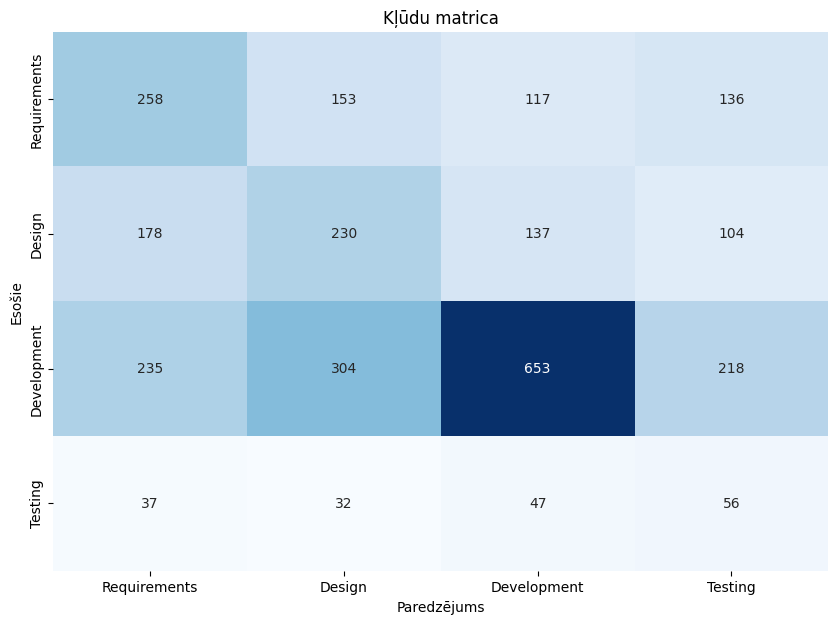

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Definējam teksta vērtībām atbilstošās skaitliskās vērtības.
categories = {
    'Requirements': 0,
    'Design': 1,
    'Development': 2,
    'Testing': 3
}

# Veidojma kļūdu matricu
plt.figure(figsize=(10, 7))
sns.heatmap(overall_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories.keys(), yticklabels=categories.keys(), cbar=False)

# Definējam nosaukumus
plt.xlabel('Paredzējums')
plt.ylabel('Esošie')
plt.title('Kļūdu matrica')
plt.show()

In [16]:
# Paredzējums
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

loaded_model = load_model('./drive/MyDrive/ColabNotebooks/TrainedModel/RNN_CV_Smote_Cikls_5.keras')

def predictPhase(bugText):
  # Pārveidojam kategorijas uz skaitļu vērtībām
  categories = {
      'Requirements': 0,
      'Design': 1,
      'Development': 2,
      'Testing': 3
  }
  # Pārveidojam skaitļu vērtības uz teksta vērtībām
  reverse_categories = {v: k for k, v in categories.items()}

  # Veicam teksta sadalīšanu marķieros
  input_sequence = tokenizer.texts_to_sequences([bugText])
  input_padded = pad_sequences(input_sequence, padding='post')

  prediction = np.argmax(model.predict(input_padded), axis=1)[0]
  return reverse_categories[prediction]


defect_Description_for_prediction = 'database title column type must be changed to integer'

predict_phase = predictPhase(defect_Description_for_prediction)
print(f"Defekta apraksts '{defect_Description_for_prediction}' attiecas uz '{predict_phase}' fāzi.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Defekta apraksts 'database title column type must be changed to integer' attiecas uz 'Development' fāzi.
